<a href="https://colab.research.google.com/github/Subhi-Dev/edge-face-detector/blob/main/IU_Face_Feature_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IU - Face Feature Detection
This is a project made for IU's Course (Project: Edge AI), it implements Face feature detection using the [DeepFace Library](https://github.com/serengil/deepface). The model is hosted on edge after converting it to the tf-lite format.

## Install Project Requirements

In [1]:
!pip install deepface matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00


## Define and save models

### Download model weights and define the structure

In [2]:
#@title Prepare Directory Structure
!mkdir -p /root/.deepface
!mkdir -p /root/.deepface/weights

In [3]:
#@title Imports
from typing import List, Union

# 3rd party dependencies
import numpy as np

# project dependencies
from deepface.models.facial_recognition import VGGFace
from deepface.commons import package_utils, weight_utils
from deepface.models.Demography import Demography
from deepface.commons.logger import Logger

logger = Logger()

# dependency configurations
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout

import tensorflow as tf

In [4]:
#@title Age Model
WEIGHTS_URL = (
    "https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5"
)


# Construct age model, download its weights and load
# Returns:
#     model (Model)

model = VGGFace.base_model()

# --------------------------

classes = 101
base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name="predictions")(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation("softmax")(base_model_output)

# --------------------------

age_model = Model(inputs=model.inputs, outputs=base_model_output)

# --------------------------

# load weights
weight_file = weight_utils.download_weights_if_necessary(
    file_name="age_model_weights.h5", source_url=WEIGHTS_URL
)

age_model = weight_utils.load_model_weights(model=age_model, weight_file=weight_file)

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5


25-08-31 03:01:55 - 🔗 age_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5 to /root/.deepface/weights/age_model_weights.h5...


100%|██████████| 539M/539M [00:06<00:00, 82.7MB/s]


In [5]:
#@title Emotion Model

# Labels for the emotions that can be detected by the model.
labels = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

WEIGHTS_URL = "https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5"


# Consruct emotion model, download and load weights
num_classes = 7

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# fully connected neural networks
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation="softmax"))

# ----------------------------

weight_file = weight_utils.download_weights_if_necessary(
    file_name="facial_expression_model_weights.h5", source_url=WEIGHTS_URL
)

emotion_model = weight_utils.load_model_weights(model=model, weight_file=weight_file)

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5


25-08-31 03:02:03 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...


100%|██████████| 5.98M/5.98M [00:00<00:00, 117MB/s]


In [6]:
#@title Gender Model

WEIGHTS_URL="https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5"

# Labels for the genders that can be detected by the model.
labels = ["Woman", "Man"]
# Construct gender model, download its weights and load
#     Returns:
#         model (Model)
model = VGGFace.base_model()

# --------------------------

classes = 2
base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name="predictions")(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation("softmax")(base_model_output)

# --------------------------

gender_model = Model(inputs=model.inputs, outputs=base_model_output)

# --------------------------

# load weights
weight_file = weight_utils.download_weights_if_necessary(
    file_name="gender_model_weights.h5", source_url=WEIGHTS_URL
)

gender_model = weight_utils.load_model_weights(
    model=gender_model, weight_file=weight_file
)


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5


25-08-31 03:02:09 - 🔗 gender_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5 to /root/.deepface/weights/gender_model_weights.h5...


100%|██████████| 537M/537M [00:06<00:00, 82.0MB/s]


### Save models in TF-lite format

In [7]:
# Age model
age_converter = tf.lite.TFLiteConverter.from_keras_model(age_model)
age_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_age_model = age_converter.convert()
with open('age_model.tflite', 'wb') as file:
    file.write(tflite_age_model)

# Emotion model
emotion_converter = tf.lite.TFLiteConverter.from_keras_model(emotion_model)
emotion_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_emotion_model = emotion_converter.convert()
with open('emotion_model.tflite', 'wb') as file:
    file.write(tflite_emotion_model)

# Gender model
gender_converter = tf.lite.TFLiteConverter.from_keras_model(gender_model)
gender_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_gender_model = gender_converter.convert()
with open('gender_model.tflite', 'wb') as file:
    file.write(tflite_gender_model)

Saved artifact at '/tmp/tmp2dofc2y_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)
Captures:
  138742052733584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052736464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052735120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052735888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052737808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052738576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052738000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052737616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052739536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052733968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138742052738

## Evaluating the models

In [9]:
# Download Evaluation dataset
!git clone https://github.com/Subhi-Dev/ffhq-features-dataset.git

Cloning into 'ffhq-features-dataset'...
remote: Enumerating objects: 70601, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 70601 (delta 24), reused 19 (delta 3), pack-reused 70560 (from 2)
Receiving objects: 100% (70601/70601), 1.29 GiB | 35.79 MiB/s, done.
Resolving deltas: 100% (69498/69498), done.
Updating files: 100% (71004/71004), done.


In [10]:
!cd ffhq-features-dataset/ && git pull

Already up to date.


In [11]:
# Step 2.1: Imports and Directory Setup
import os
import json
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Suppress TensorFlow and other warnings for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# DeepFace imports for model building
from deepface.models.facial_recognition import VGGFace
from deepface.commons import weight_utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout


In [12]:
# Configuration Parameters
DATASET_SIZE = 1000 # @param {"type":"integer","placeholder":"1000"}
IMAGE_DIR = '/content/ffhq-features-dataset/00000' # @param {"type":"string","placeholder":"1000"}
JSON_DIR = '/content/ffhq-features-dataset/json'# @param {"type":"string","placeholder":"1000"}

# --- Model Labels ---
EMOTION_LABELS = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
GENDER_LABELS = ["Woman", "Man"]

# --- Mappings from JSON to Model Labels ---
# JSON emotion keys have suffixes ('happiness' vs 'happy')
JSON_EMOTION_MAP = {
    "anger": "angry", "disgust": "disgust", "fear": "fear",
    "happiness": "happy", "sadness": "sad", "surprise": "surprise",
    "neutral": "neutral"
}
JSON_GENDER_MAP = {"female": "Woman", "male": "Man"}

# --- Lists to store ground truth and predictions ---
true_ages, pred_ages = [], []
true_genders, pred_genders = [], []
true_emotions, pred_emotions = [], []

# --- Evaluation Loop ---
print(f"Evaluating models on the first {DATASET_SIZE} images...")
for i in tqdm(range(DATASET_SIZE)):
    image_filename = f"{i:05d}.png"
    json_filename = f"{i:05d}.json"
    image_path = os.path.join(IMAGE_DIR, image_filename)
    json_path = os.path.join(JSON_DIR, json_filename)

    # --- 1. Load Ground Truth from JSON ---
    with open(json_path, 'r') as f:
        data = json.load(f)[0]['faceAttributes']

    true_age = data['age']
    true_gender_str = data['gender']
    # Find the dominant emotion from the JSON scores
    emotion_scores = {k: v for k, v in data['emotion'].items() if k in JSON_EMOTION_MAP}
    true_emotion_str = max(emotion_scores, key=emotion_scores.get)

    true_ages.append(true_age)
    true_genders.append(JSON_GENDER_MAP[true_gender_str])
    true_emotions.append(JSON_EMOTION_MAP[true_emotion_str])

    # --- 2. Load and Preprocess Image ---
    # For Age and Gender Models (224x224 RGB)
    img_age_gender = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_age_gender_arr = tf.keras.utils.img_to_array(img_age_gender)
    img_age_gender_arr = np.expand_dims(img_age_gender_arr, axis=0)
    # VGG-Face preprocessing: BGR mean subtraction
    img_age_gender_arr = img_age_gender_arr[..., ::-1] # RGB to BGR
    mean = [93.5940, 104.7624, 129.1863]
    img_age_gender_arr[..., 0] -= mean[0]
    img_age_gender_arr[..., 1] -= mean[1]
    img_age_gender_arr[..., 2] -= mean[2]


    # For Emotion Model (48x48 Grayscale)
    img_emotion = tf.keras.utils.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_emotion_arr = tf.keras.utils.img_to_array(img_emotion)
    img_emotion_arr = np.expand_dims(img_emotion_arr, axis=0)
    img_emotion_arr /= 255.0  # Normalize

    # --- 3. Make Predictions ---
    # Age Prediction
    age_dist = age_model.predict(img_age_gender_arr, verbose=0)[0]
    predicted_age = np.sum(age_dist * np.arange(0, 101))
    pred_ages.append(predicted_age)

    # Gender Prediction
    gender_dist = gender_model.predict(img_age_gender_arr, verbose=0)[0]
    predicted_gender = GENDER_LABELS[np.argmax(gender_dist)]
    pred_genders.append(predicted_gender)

    # Emotion Prediction
    emotion_dist = emotion_model.predict(img_emotion_arr, verbose=0)[0]
    predicted_emotion = EMOTION_LABELS[np.argmax(emotion_dist)]
    pred_emotions.append(predicted_emotion)

Evaluating models on the first 1000 images...


100%|██████████| 1000/1000 [27:58<00:00,  1.68s/it]

✅ Evaluation complete.


In [15]:
# Calculate Age Metrics
age_mae = mean_absolute_error(true_ages, pred_ages)
age_errors = np.abs(np.array(true_ages) - np.array(pred_ages))
age_accuracy = np.sum(age_errors <= 5) / len(true_ages)

# Calculate Gender Metrics
gender_accuracy = accuracy_score(true_genders, pred_genders)
gender_precision = precision_score(true_genders, pred_genders, average='macro')
gender_recall = recall_score(true_genders, pred_genders, average='macro')
gender_f1 = f1_score(true_genders, pred_genders, average='macro')

# Calculate Emotion Metrics
emotion_accuracy = accuracy_score(true_emotions, pred_emotions)
emotion_precision = precision_score(true_emotions, pred_emotions, average='macro', zero_division=0)
emotion_recall = recall_score(true_emotions, pred_emotions, average='macro', zero_division=0)
emotion_f1 = f1_score(true_emotions, pred_emotions, average='macro', zero_division=0)

# Summary:
print("   MODEL EVALUATION SUMMARY")

print("\n Age Prediction Model")
print(f"Mean Absolute Error (MAE): {age_mae:.2f} years")
print(f"Accuracy (within 5 years): {age_accuracy:.2%}")

print("\n Gender Prediction Model")
print(f"Accuracy:  {gender_accuracy:.2%}")
print(f"Precision: {gender_precision:.2%}")
print(f"Recall:    {gender_recall:.2%}")
print(f"F1-Score:  {gender_f1:.2%}")

print("\n Emotion Prediction Model")
print(f"Accuracy:  {emotion_accuracy:.2%}")
print(f"Precision: {emotion_precision:.2%}")
print(f"Recall:    {emotion_recall:.2%}")
print(f"F1-Score:  {emotion_f1:.2%}")


   MODEL EVALUATION SUMMARY

 Age Prediction Model
Mean Absolute Error (MAE): 8.53 years
Accuracy (within 5 years): 38.40%

 Gender Prediction Model
Accuracy:  88.50%
Precision: 88.39%
Recall:    88.63%
F1-Score:  88.46%

 Emotion Prediction Model
Accuracy:  51.30%
Precision: 23.02%
Recall:    18.48%
F1-Score:  19.44%


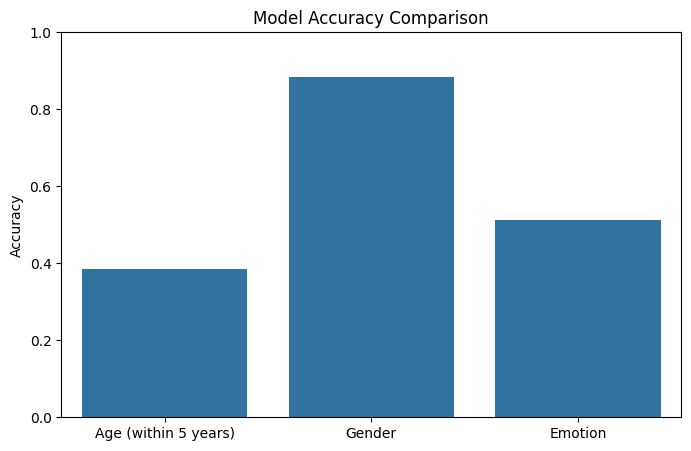

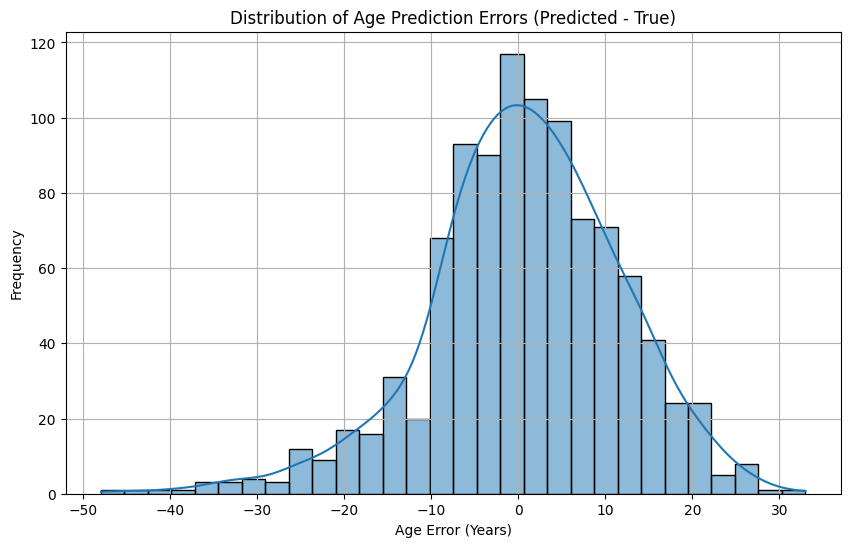

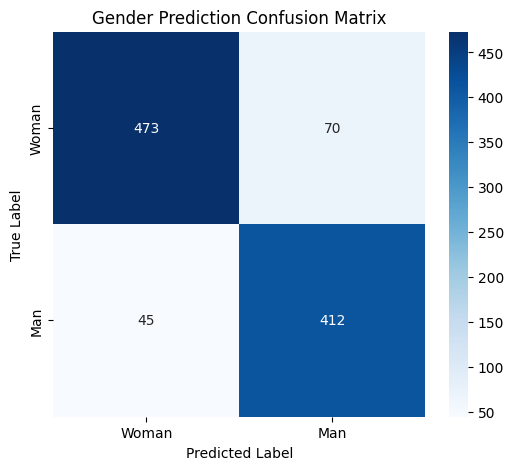

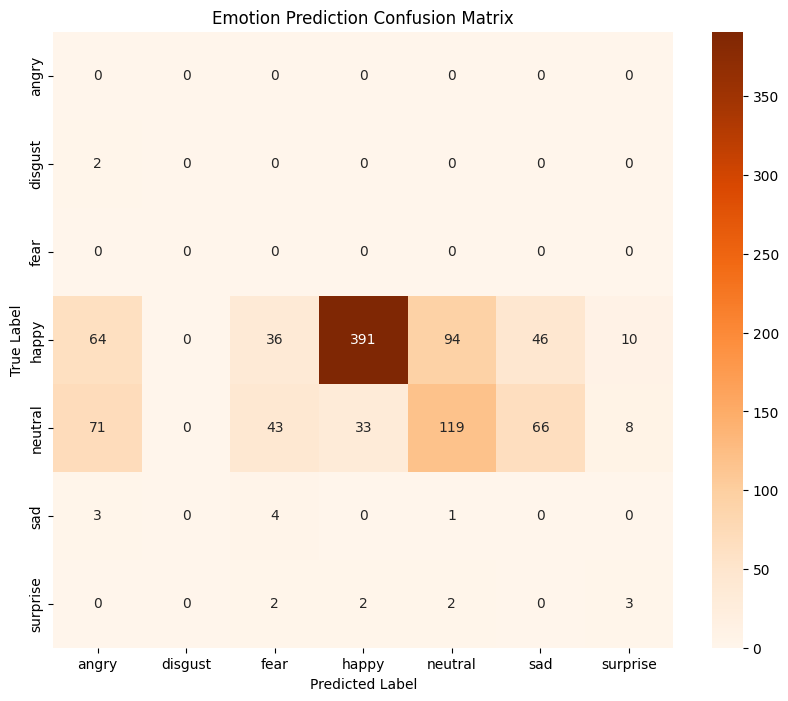

In [16]:
# Bar Chart for Model Accuracy
accuracies = {
    'Age (within 5 years)': age_accuracy,
    'Gender': gender_accuracy,
    'Emotion': emotion_accuracy
}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Histogram of Age Prediction Errors
age_prediction_errors = np.array(pred_ages) - np.array(true_ages)
plt.figure(figsize=(10, 6))
sns.histplot(age_prediction_errors, bins=30, kde=True)
plt.title('Distribution of Age Prediction Errors (Predicted - True)')
plt.xlabel('Age Error (Years)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Confusion Matrix for Gender Model
cm_gender = confusion_matrix(true_genders, pred_genders, labels=GENDER_LABELS)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues',
            xticklabels=GENDER_LABELS, yticklabels=GENDER_LABELS)
plt.title('Gender Prediction Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Confusion Matrix for Emotion Model
# Filter out labels that might not appear in the first 1000 images for a cleaner matrix
sorted_emotion_labels = sorted(list(set(true_emotions) | set(pred_emotions)))
cm_emotion = confusion_matrix(true_emotions, pred_emotions, labels=sorted_emotion_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_emotion, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sorted_emotion_labels, yticklabels=sorted_emotion_labels)
plt.title('Emotion Prediction Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()